https://github.com/sofa13/csi5138_a4/blob/master/WGAN-MNIST.ipynb

In [1]:
import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_data_format('channels_first')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

def train_input_dim(in_dim,train_epoches,train_batchSize):



  randomDim = in_dim

  # Load MNIST data
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5)/127.5
  X_train = X_train.reshape(60000, 784)

  # Optimizer
  adam = Adam(lr=0.0002, beta_1=0.5)

  generator = Sequential()
  generator.add(Dense(128, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(256))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  generator.compile(loss='binary_crossentropy', optimizer=adam)

  discriminator = Sequential()
  discriminator.add(Dense(512, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(128))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(1, activation='sigmoid'))
  discriminator.compile(loss='binary_crossentropy', optimizer=adam)

  # Combined network
  discriminator.trainable = False
  ganInput = Input(shape=(randomDim,))
  x = generator(ganInput)
  ganOutput = discriminator(x)
  gan = Model(inputs=ganInput, outputs=ganOutput)
  gan.compile(loss='binary_crossentropy', optimizer=adam)

  dLosses = []
  gLosses = []

  # Plot the loss from each batch
  def plotLoss(epoch):
      plt.figure(figsize=(10, 8))
      plt.plot(dLosses, label='Discriminitive loss')
      plt.plot(gLosses, label='Generative loss')
      plt.title('GAN with latant space of %s '%in_dim)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      # plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

  # Create a wall of generated MNIST images
  def plotGeneratedImages(epoch, examples=36, dim=(6, 6), figsize=(6, 8)):
      noise = np.random.normal(0, 1, size=[examples, randomDim])
      generatedImages = generator.predict(noise)
      generatedImages = generatedImages.reshape(examples, 28, 28)
      
      
      fig = plt.figure(figsize=figsize)
      fig.suptitle('GAN with latant space of %s and epoch = %s'%(in_dim,epoch))

      # plt.title('GAN with latant space of %s and epoch = %s'%(in_dim,epoch))
      
      for i in range(generatedImages.shape[0]):
          
          plt.subplot(dim[0], dim[1], i+1)
          plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
          plt.axis('off')
      
      plt.tight_layout()
      
      # plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

  # Save the generator and discriminator networks (and weights) for later use
  def saveModels(epoch):
      generator.save('models/gan_generator_epoch_%d.h5' % epoch)
      discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

  def train(epochs, batchSize):
      batchCount = X_train.shape[0] / batchSize
      print('Epochs:', epochs)
      print('Batch size:', batchSize)
      print('Batches per epoch:', batchCount)
      print('randomDim: ', randomDim)

      for e in range(1, epochs+1):
          print('-'*15, 'Epoch %d' % e, '-'*15)
          for _ in tqdm(range(int(batchCount))):
              # Get a random set of input noise and images
              noise = np.random.normal(0, 1, size=[batchSize, randomDim])
              imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

              # Generate fake MNIST images
              generatedImages = generator.predict(noise)
              # print np.shape(imageBatch), np.shape(generatedImages)
              X = np.concatenate([imageBatch, generatedImages])

              # Labels for generated and real data
              yDis = np.zeros(2*batchSize)
              # One-sided label smoothing
              yDis[:batchSize] = 0.9

              # Train discriminator
              discriminator.trainable = True
              dloss = discriminator.train_on_batch(X, yDis)

              # Train generator
              noise = np.random.normal(0, 1, size=[batchSize, randomDim])
              yGen = np.ones(batchSize)
              discriminator.trainable = False
              gloss = gan.train_on_batch(noise, yGen)

          # Store loss of most recent batch from this epoch
          dLosses.append(dloss)
          gLosses.append(gloss)

          if e == 1 or e % 10 == 0:
              plotGeneratedImages(e)
              saveModels(e)

      # Plot losses from every epoch
      plotLoss(e)
  train(train_epoches, train_batchSize)

11493376/11490434 [==============================] - 0s 0us/step


  0%|          | 0/117 [00:00<?, ?it/s]

Epochs: 200
Batch size: 512
Batches per epoch: 117.1875
randomDim:  5
--------------- Epoch 1 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.46it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.49it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.18it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.81it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.59it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.07it/s]

--------------- Epoch 7 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.61it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.97it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.78it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.05it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.51it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.46it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

--------------- Epoch 20 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.00it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.22it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.77it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.09it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.53it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.16it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.79it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.43it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.33it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.64it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.13it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.67it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.31it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.72it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.77it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.65it/s]

--------------- Epoch 40 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.22it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.29it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.39it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.65it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.69it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.81it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.87it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.85it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.70it/s]

--------------- Epoch 50 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 51 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 52 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.68it/s]

--------------- Epoch 53 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.73it/s]

--------------- Epoch 54 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.11it/s]

--------------- Epoch 55 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.87it/s]

--------------- Epoch 56 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.18it/s]

--------------- Epoch 57 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.96it/s]

--------------- Epoch 58 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 59 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 60 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 61 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 62 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 63 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 64 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.96it/s]

--------------- Epoch 65 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.70it/s]

--------------- Epoch 66 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.36it/s]

--------------- Epoch 67 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.18it/s]

--------------- Epoch 68 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.85it/s]

--------------- Epoch 69 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.12it/s]

--------------- Epoch 70 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

--------------- Epoch 71 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 72 ---------------


  2%|▏         | 2/117 [00:00<00:08, 13.90it/s]

--------------- Epoch 73 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

--------------- Epoch 74 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.14it/s]

--------------- Epoch 75 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.98it/s]

--------------- Epoch 76 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.25it/s]

--------------- Epoch 77 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.32it/s]

--------------- Epoch 78 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

--------------- Epoch 79 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.45it/s]

--------------- Epoch 80 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 81 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.80it/s]

--------------- Epoch 82 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.12it/s]

--------------- Epoch 83 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.08it/s]

--------------- Epoch 84 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.18it/s]

--------------- Epoch 85 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 86 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.44it/s]

--------------- Epoch 87 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.30it/s]

--------------- Epoch 88 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 89 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.48it/s]

--------------- Epoch 90 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 91 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.42it/s]

--------------- Epoch 92 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.51it/s]

--------------- Epoch 93 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

--------------- Epoch 94 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.21it/s]

--------------- Epoch 95 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 96 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 97 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.33it/s]

--------------- Epoch 98 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.38it/s]

--------------- Epoch 99 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.41it/s]

--------------- Epoch 100 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 101 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.62it/s]

--------------- Epoch 102 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 103 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 104 ---------------


  0%|          | 0/117 [00:00<?, ?it/s]

--------------- Epoch 105 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.40it/s]

--------------- Epoch 106 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 107 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.64it/s]

--------------- Epoch 108 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.12it/s]

--------------- Epoch 109 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.20it/s]

--------------- Epoch 110 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.68it/s]

--------------- Epoch 111 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.23it/s]

--------------- Epoch 112 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.52it/s]

--------------- Epoch 113 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.43it/s]

--------------- Epoch 114 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.25it/s]

--------------- Epoch 115 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.00it/s]

--------------- Epoch 116 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.24it/s]

--------------- Epoch 117 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

--------------- Epoch 118 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.88it/s]

--------------- Epoch 119 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.30it/s]

--------------- Epoch 120 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.01it/s]

--------------- Epoch 121 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.01it/s]

--------------- Epoch 122 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.39it/s]

--------------- Epoch 123 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 124 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 125 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.59it/s]

--------------- Epoch 126 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.30it/s]

--------------- Epoch 127 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.31it/s]

--------------- Epoch 128 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.71it/s]

--------------- Epoch 129 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

--------------- Epoch 130 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.42it/s]

--------------- Epoch 131 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 132 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 133 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.22it/s]

--------------- Epoch 134 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.99it/s]

--------------- Epoch 135 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.43it/s]

--------------- Epoch 136 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.27it/s]

--------------- Epoch 137 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.52it/s]

--------------- Epoch 138 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.45it/s]

--------------- Epoch 139 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.23it/s]

--------------- Epoch 140 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.37it/s]

--------------- Epoch 141 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.16it/s]

--------------- Epoch 142 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 143 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 144 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

--------------- Epoch 145 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.52it/s]

--------------- Epoch 146 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

--------------- Epoch 147 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.79it/s]

--------------- Epoch 148 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.50it/s]

--------------- Epoch 149 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.26it/s]

--------------- Epoch 150 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 151 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 152 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.97it/s]

--------------- Epoch 153 ---------------


  2%|▏         | 2/117 [00:00<00:08, 13.98it/s]

--------------- Epoch 154 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 155 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

--------------- Epoch 156 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.79it/s]

--------------- Epoch 157 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 158 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.47it/s]

--------------- Epoch 159 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.28it/s]

--------------- Epoch 160 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 161 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.37it/s]

--------------- Epoch 162 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.17it/s]

--------------- Epoch 163 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.24it/s]

--------------- Epoch 164 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 165 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

--------------- Epoch 166 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.97it/s]

--------------- Epoch 167 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 168 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

--------------- Epoch 169 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.03it/s]

--------------- Epoch 170 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

--------------- Epoch 171 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.80it/s]

--------------- Epoch 172 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.24it/s]

--------------- Epoch 173 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.21it/s]

--------------- Epoch 174 ---------------


  0%|          | 0/117 [00:00<?, ?it/s]

--------------- Epoch 175 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.22it/s]

--------------- Epoch 176 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.85it/s]

--------------- Epoch 177 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.09it/s]

--------------- Epoch 178 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.14it/s]

--------------- Epoch 179 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.60it/s]

--------------- Epoch 180 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.72it/s]

--------------- Epoch 181 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.79it/s]

--------------- Epoch 182 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 183 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.16it/s]

--------------- Epoch 184 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.40it/s]

--------------- Epoch 185 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 186 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.71it/s]

--------------- Epoch 187 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.42it/s]

--------------- Epoch 188 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 189 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.69it/s]

--------------- Epoch 190 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.25it/s]

--------------- Epoch 191 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.18it/s]

--------------- Epoch 192 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.92it/s]

--------------- Epoch 193 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.47it/s]

--------------- Epoch 194 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.23it/s]

--------------- Epoch 195 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 196 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.10it/s]

--------------- Epoch 197 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.35it/s]

--------------- Epoch 198 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.33it/s]

--------------- Epoch 199 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

--------------- Epoch 200 ---------------


100%|██████████| 117/117 [00:07<00:00, 15.89it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  0%|          | 0/117 [00:00<?, ?it/s]

Epochs: 200
Batch size: 512
Batches per epoch: 117.1875
randomDim:  10
--------------- Epoch 1 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.94it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.35it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.17it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/117 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.11it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.86it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.54it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.94it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.47it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 2/117 [00:00<00:08, 13.99it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.54it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.67it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.90it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.26it/s]

--------------- Epoch 20 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.04it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.27it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.36it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.70it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.26it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.51it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.76it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.49it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.00it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.59it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.25it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

--------------- Epoch 40 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.20it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.47it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.30it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.86it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.59it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.58it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.36it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.36it/s]

--------------- Epoch 50 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.16it/s]

--------------- Epoch 51 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.00it/s]

--------------- Epoch 52 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 53 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 54 ---------------


  2%|▏         | 2/117 [00:00<00:08, 13.54it/s]

--------------- Epoch 55 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 56 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 57 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.20it/s]

--------------- Epoch 58 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.67it/s]

--------------- Epoch 59 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.79it/s]

--------------- Epoch 60 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.09it/s]

--------------- Epoch 61 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

--------------- Epoch 62 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

--------------- Epoch 63 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.32it/s]

--------------- Epoch 64 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.41it/s]

--------------- Epoch 65 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.77it/s]

--------------- Epoch 66 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.14it/s]

--------------- Epoch 67 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 68 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

--------------- Epoch 69 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.32it/s]

--------------- Epoch 70 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.58it/s]

--------------- Epoch 71 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 72 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.52it/s]

--------------- Epoch 73 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.83it/s]

--------------- Epoch 74 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.35it/s]

--------------- Epoch 75 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.15it/s]

--------------- Epoch 76 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.46it/s]

--------------- Epoch 77 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 78 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

--------------- Epoch 79 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

--------------- Epoch 80 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.98it/s]

--------------- Epoch 81 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.50it/s]

--------------- Epoch 82 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.34it/s]

--------------- Epoch 83 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.72it/s]

--------------- Epoch 84 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.72it/s]

--------------- Epoch 85 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.05it/s]

--------------- Epoch 86 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

--------------- Epoch 87 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.99it/s]

--------------- Epoch 88 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.45it/s]

--------------- Epoch 89 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.45it/s]

--------------- Epoch 90 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.81it/s]

--------------- Epoch 91 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.61it/s]

--------------- Epoch 92 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

--------------- Epoch 93 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.71it/s]

--------------- Epoch 94 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.51it/s]

--------------- Epoch 95 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.14it/s]

--------------- Epoch 96 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 97 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.82it/s]

--------------- Epoch 98 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.56it/s]

--------------- Epoch 99 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 100 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.64it/s]

--------------- Epoch 101 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.98it/s]

--------------- Epoch 102 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

--------------- Epoch 103 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.40it/s]

--------------- Epoch 104 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.17it/s]

--------------- Epoch 105 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.64it/s]

--------------- Epoch 106 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.01it/s]

--------------- Epoch 107 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.07it/s]

--------------- Epoch 108 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.33it/s]

--------------- Epoch 109 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.11it/s]

--------------- Epoch 110 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 111 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

--------------- Epoch 112 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.47it/s]

--------------- Epoch 113 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 114 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.22it/s]

--------------- Epoch 115 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.23it/s]

--------------- Epoch 116 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.46it/s]

--------------- Epoch 117 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.62it/s]

--------------- Epoch 118 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.69it/s]

--------------- Epoch 119 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.36it/s]

--------------- Epoch 120 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

--------------- Epoch 121 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

--------------- Epoch 122 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.60it/s]

--------------- Epoch 123 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

--------------- Epoch 124 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.32it/s]

--------------- Epoch 125 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 126 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.79it/s]

--------------- Epoch 127 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.84it/s]

--------------- Epoch 128 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 129 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.28it/s]

--------------- Epoch 130 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.97it/s]

--------------- Epoch 131 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.43it/s]

--------------- Epoch 132 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 133 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

--------------- Epoch 134 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.67it/s]

--------------- Epoch 135 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.64it/s]

--------------- Epoch 136 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

--------------- Epoch 137 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.25it/s]

--------------- Epoch 138 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 139 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.52it/s]

--------------- Epoch 140 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.71it/s]

--------------- Epoch 141 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 142 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.12it/s]

--------------- Epoch 143 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.10it/s]

--------------- Epoch 144 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 145 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.40it/s]

--------------- Epoch 146 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 147 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 148 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.49it/s]

--------------- Epoch 149 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.90it/s]

--------------- Epoch 150 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 151 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.33it/s]

--------------- Epoch 152 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 153 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.96it/s]

--------------- Epoch 154 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.81it/s]

--------------- Epoch 155 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.20it/s]

--------------- Epoch 156 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.71it/s]

--------------- Epoch 157 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.37it/s]

--------------- Epoch 158 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.81it/s]

--------------- Epoch 159 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.58it/s]

--------------- Epoch 160 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 161 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.77it/s]

--------------- Epoch 162 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 163 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 164 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

--------------- Epoch 165 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

--------------- Epoch 166 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 167 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 168 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.08it/s]

--------------- Epoch 169 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.27it/s]

--------------- Epoch 170 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.51it/s]

--------------- Epoch 171 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.58it/s]

--------------- Epoch 172 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.44it/s]

--------------- Epoch 173 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.69it/s]

--------------- Epoch 174 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.34it/s]

--------------- Epoch 175 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.29it/s]

--------------- Epoch 176 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

--------------- Epoch 177 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.22it/s]

--------------- Epoch 178 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 179 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.39it/s]

--------------- Epoch 180 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 181 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.50it/s]

--------------- Epoch 182 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.26it/s]

--------------- Epoch 183 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.21it/s]

--------------- Epoch 184 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.64it/s]

--------------- Epoch 185 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

--------------- Epoch 186 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.59it/s]

--------------- Epoch 187 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.56it/s]

--------------- Epoch 188 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.99it/s]

--------------- Epoch 189 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.90it/s]

--------------- Epoch 190 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

--------------- Epoch 191 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.96it/s]

--------------- Epoch 192 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 193 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.83it/s]

--------------- Epoch 194 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.90it/s]

--------------- Epoch 195 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

--------------- Epoch 196 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.08it/s]

--------------- Epoch 197 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 198 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.15it/s]

--------------- Epoch 199 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.84it/s]

--------------- Epoch 200 ---------------


  0%|          | 0/117 [00:00<?, ?it/s]

Epochs: 200
Batch size: 512
Batches per epoch: 117.1875
randomDim:  15
--------------- Epoch 1 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.18it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

--------------- Epoch 7 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.57it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.94it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.73it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.69it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.41it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.56it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.30it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 2/117 [00:00<00:08, 13.95it/s]

--------------- Epoch 20 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.24it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.62it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.22it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.72it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.31it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.52it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.76it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.46it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.27it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.14it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.90it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.01it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.51it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.69it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.43it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 40 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.86it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.28it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.17it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.65it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.56it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.64it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.23it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.61it/s]

--------------- Epoch 50 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.49it/s]

--------------- Epoch 51 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.88it/s]

--------------- Epoch 52 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.58it/s]

--------------- Epoch 53 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 54 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.89it/s]

--------------- Epoch 55 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.23it/s]

--------------- Epoch 56 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.76it/s]

--------------- Epoch 57 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 58 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.69it/s]

--------------- Epoch 59 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.02it/s]

--------------- Epoch 60 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 61 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.31it/s]

--------------- Epoch 62 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.39it/s]

--------------- Epoch 63 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.82it/s]

--------------- Epoch 64 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.88it/s]

--------------- Epoch 65 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.24it/s]

--------------- Epoch 66 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.77it/s]

--------------- Epoch 67 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.67it/s]

--------------- Epoch 68 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.30it/s]

--------------- Epoch 69 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 70 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.61it/s]

--------------- Epoch 71 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.67it/s]

--------------- Epoch 72 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.95it/s]

--------------- Epoch 73 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.59it/s]

--------------- Epoch 74 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 75 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.98it/s]

--------------- Epoch 76 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.07it/s]

--------------- Epoch 77 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.92it/s]

--------------- Epoch 78 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

--------------- Epoch 79 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.40it/s]

--------------- Epoch 80 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.59it/s]

--------------- Epoch 81 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.91it/s]

--------------- Epoch 82 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.79it/s]

--------------- Epoch 83 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.30it/s]

--------------- Epoch 84 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

--------------- Epoch 85 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.98it/s]

--------------- Epoch 86 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.83it/s]

--------------- Epoch 87 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.36it/s]

--------------- Epoch 88 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.25it/s]

--------------- Epoch 89 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 90 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.05it/s]

--------------- Epoch 91 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

--------------- Epoch 92 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.05it/s]

--------------- Epoch 93 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.53it/s]

--------------- Epoch 94 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 95 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 96 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.82it/s]

--------------- Epoch 97 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 98 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.53it/s]

--------------- Epoch 99 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.17it/s]

--------------- Epoch 100 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.69it/s]

--------------- Epoch 101 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

--------------- Epoch 102 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.31it/s]

--------------- Epoch 103 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.68it/s]

--------------- Epoch 104 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.87it/s]

--------------- Epoch 105 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 106 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.65it/s]

--------------- Epoch 107 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.98it/s]

--------------- Epoch 108 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.07it/s]

--------------- Epoch 109 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.10it/s]

--------------- Epoch 110 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 111 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.38it/s]

--------------- Epoch 112 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 113 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.87it/s]

--------------- Epoch 114 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.76it/s]

--------------- Epoch 115 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.51it/s]

--------------- Epoch 116 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.35it/s]

--------------- Epoch 117 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.84it/s]

--------------- Epoch 118 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.17it/s]

--------------- Epoch 119 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.57it/s]

--------------- Epoch 120 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.97it/s]

--------------- Epoch 121 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.46it/s]

--------------- Epoch 122 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 123 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

--------------- Epoch 124 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.70it/s]

--------------- Epoch 125 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.20it/s]

--------------- Epoch 126 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.21it/s]

--------------- Epoch 127 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.73it/s]

--------------- Epoch 128 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.67it/s]

--------------- Epoch 129 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.59it/s]

--------------- Epoch 130 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 131 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 132 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.34it/s]

--------------- Epoch 133 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 134 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 135 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.38it/s]

--------------- Epoch 136 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.39it/s]

--------------- Epoch 137 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.58it/s]

--------------- Epoch 138 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.53it/s]

--------------- Epoch 139 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.97it/s]

--------------- Epoch 140 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.51it/s]

--------------- Epoch 141 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.44it/s]

--------------- Epoch 142 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 143 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.96it/s]

--------------- Epoch 144 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.08it/s]

--------------- Epoch 145 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.57it/s]

--------------- Epoch 146 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.86it/s]

--------------- Epoch 147 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.53it/s]

--------------- Epoch 148 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.15it/s]

--------------- Epoch 149 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.09it/s]

--------------- Epoch 150 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.18it/s]

--------------- Epoch 151 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.11it/s]

--------------- Epoch 152 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.09it/s]

--------------- Epoch 153 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.90it/s]

--------------- Epoch 154 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.94it/s]

--------------- Epoch 155 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.41it/s]

--------------- Epoch 156 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 157 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.57it/s]

--------------- Epoch 158 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.23it/s]

--------------- Epoch 159 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 160 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.46it/s]

--------------- Epoch 161 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.49it/s]

--------------- Epoch 162 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.49it/s]

--------------- Epoch 163 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

--------------- Epoch 164 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.68it/s]

--------------- Epoch 165 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.05it/s]

--------------- Epoch 166 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.21it/s]

--------------- Epoch 167 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 168 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

--------------- Epoch 169 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.45it/s]

--------------- Epoch 170 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.20it/s]

--------------- Epoch 171 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.54it/s]

--------------- Epoch 172 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.32it/s]

--------------- Epoch 173 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.68it/s]

--------------- Epoch 174 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.67it/s]

--------------- Epoch 175 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.47it/s]

--------------- Epoch 176 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.87it/s]

--------------- Epoch 177 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.03it/s]

--------------- Epoch 178 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.29it/s]

--------------- Epoch 179 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.64it/s]

--------------- Epoch 180 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 181 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.91it/s]

--------------- Epoch 182 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.33it/s]

--------------- Epoch 183 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.94it/s]

--------------- Epoch 184 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 185 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.91it/s]

--------------- Epoch 186 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

--------------- Epoch 187 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 188 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.07it/s]

--------------- Epoch 189 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.07it/s]

--------------- Epoch 190 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.67it/s]

--------------- Epoch 191 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.49it/s]

--------------- Epoch 192 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

--------------- Epoch 193 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.69it/s]

--------------- Epoch 194 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.30it/s]

--------------- Epoch 195 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

--------------- Epoch 196 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.54it/s]

--------------- Epoch 197 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 198 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.47it/s]

--------------- Epoch 199 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.23it/s]

--------------- Epoch 200 ---------------


  0%|          | 0/117 [00:00<?, ?it/s]

Epochs: 200
Batch size: 512
Batches per epoch: 117.1875
randomDim:  20
--------------- Epoch 1 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.12it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.16it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.08it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.19it/s]

--------------- Epoch 7 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.25it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.83it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.17it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.10it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.33it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.87it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.59it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.31it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.17it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.83it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.42it/s]

--------------- Epoch 20 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.77it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.78it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.18it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.80it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.88it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.54it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.18it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.81it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.53it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.11it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.42it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.24it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.02it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.59it/s]

--------------- Epoch 40 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.67it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.21it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.72it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.99it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.91it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.47it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.07it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.79it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.86it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.77it/s]

--------------- Epoch 50 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

--------------- Epoch 51 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.99it/s]

--------------- Epoch 52 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.40it/s]

--------------- Epoch 53 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 54 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.76it/s]

--------------- Epoch 55 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

--------------- Epoch 56 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.24it/s]

--------------- Epoch 57 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.61it/s]

--------------- Epoch 58 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

--------------- Epoch 59 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.43it/s]

--------------- Epoch 60 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 61 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.62it/s]

--------------- Epoch 62 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 63 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.79it/s]

--------------- Epoch 64 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.03it/s]

--------------- Epoch 65 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

--------------- Epoch 66 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.17it/s]

--------------- Epoch 67 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.79it/s]

--------------- Epoch 68 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 69 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.12it/s]

--------------- Epoch 70 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.76it/s]

--------------- Epoch 71 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.55it/s]

--------------- Epoch 72 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.31it/s]

--------------- Epoch 73 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.43it/s]

--------------- Epoch 74 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.37it/s]

--------------- Epoch 75 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 76 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.28it/s]

--------------- Epoch 77 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 78 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.17it/s]

--------------- Epoch 79 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.86it/s]

--------------- Epoch 80 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.77it/s]

--------------- Epoch 81 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.60it/s]

--------------- Epoch 82 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.58it/s]

--------------- Epoch 83 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.22it/s]

--------------- Epoch 84 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.05it/s]

--------------- Epoch 85 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.21it/s]

--------------- Epoch 86 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.24it/s]

--------------- Epoch 87 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 88 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.32it/s]

--------------- Epoch 89 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.27it/s]

--------------- Epoch 90 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.65it/s]

--------------- Epoch 91 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.40it/s]

--------------- Epoch 92 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.82it/s]

--------------- Epoch 93 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.37it/s]

--------------- Epoch 94 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

--------------- Epoch 95 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 96 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.59it/s]

--------------- Epoch 97 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.40it/s]

--------------- Epoch 98 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.74it/s]

--------------- Epoch 99 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.97it/s]

--------------- Epoch 100 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 101 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

--------------- Epoch 102 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.79it/s]

--------------- Epoch 103 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 104 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.50it/s]

--------------- Epoch 105 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.32it/s]

--------------- Epoch 106 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.66it/s]

--------------- Epoch 107 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.51it/s]

--------------- Epoch 108 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.92it/s]

--------------- Epoch 109 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.43it/s]

--------------- Epoch 110 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

--------------- Epoch 111 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.04it/s]

--------------- Epoch 112 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 113 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.56it/s]

--------------- Epoch 114 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.64it/s]

--------------- Epoch 115 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.57it/s]

--------------- Epoch 116 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.21it/s]

--------------- Epoch 117 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.48it/s]

--------------- Epoch 118 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.42it/s]

--------------- Epoch 119 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.85it/s]

--------------- Epoch 120 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.85it/s]

--------------- Epoch 121 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.06it/s]

--------------- Epoch 122 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.37it/s]

--------------- Epoch 123 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.02it/s]

--------------- Epoch 124 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.29it/s]

--------------- Epoch 125 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.25it/s]

--------------- Epoch 126 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.71it/s]

--------------- Epoch 127 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.97it/s]

--------------- Epoch 128 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

--------------- Epoch 129 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 130 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

--------------- Epoch 131 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.13it/s]

--------------- Epoch 132 ---------------


  0%|          | 0/117 [00:00<?, ?it/s]

--------------- Epoch 133 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 134 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.69it/s]

--------------- Epoch 135 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.11it/s]

--------------- Epoch 136 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.35it/s]

--------------- Epoch 137 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.19it/s]

--------------- Epoch 138 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.44it/s]

--------------- Epoch 139 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

--------------- Epoch 140 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.84it/s]

--------------- Epoch 141 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.21it/s]

--------------- Epoch 142 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.45it/s]

--------------- Epoch 143 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.81it/s]

--------------- Epoch 144 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.90it/s]

--------------- Epoch 145 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.14it/s]

--------------- Epoch 146 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.92it/s]

--------------- Epoch 147 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

--------------- Epoch 148 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.72it/s]

--------------- Epoch 149 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.32it/s]

--------------- Epoch 150 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.71it/s]

--------------- Epoch 151 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.36it/s]

--------------- Epoch 152 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.25it/s]

--------------- Epoch 153 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.31it/s]

--------------- Epoch 154 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 155 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.41it/s]

--------------- Epoch 156 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.33it/s]

--------------- Epoch 157 ---------------


  2%|▏         | 2/117 [00:00<00:06, 17.40it/s]

--------------- Epoch 158 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 159 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.20it/s]

--------------- Epoch 160 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.62it/s]

--------------- Epoch 161 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.97it/s]

--------------- Epoch 162 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.38it/s]

--------------- Epoch 163 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.72it/s]

--------------- Epoch 164 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.75it/s]

--------------- Epoch 165 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.89it/s]

--------------- Epoch 166 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.82it/s]

--------------- Epoch 167 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.86it/s]

--------------- Epoch 168 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.93it/s]

--------------- Epoch 169 ---------------


  2%|▏         | 2/117 [00:00<00:06, 17.03it/s]

--------------- Epoch 170 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.55it/s]

--------------- Epoch 171 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.68it/s]

--------------- Epoch 172 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.51it/s]

--------------- Epoch 173 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.52it/s]

--------------- Epoch 174 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.85it/s]

--------------- Epoch 175 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.57it/s]

--------------- Epoch 176 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.06it/s]

--------------- Epoch 177 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.98it/s]

--------------- Epoch 178 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.83it/s]

--------------- Epoch 179 ---------------


  2%|▏         | 2/117 [00:00<00:06, 17.06it/s]

--------------- Epoch 180 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.78it/s]

--------------- Epoch 181 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.19it/s]

--------------- Epoch 182 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.88it/s]

--------------- Epoch 183 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.95it/s]

--------------- Epoch 184 ---------------


  2%|▏         | 2/117 [00:00<00:06, 17.45it/s]

--------------- Epoch 185 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.45it/s]

--------------- Epoch 186 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.48it/s]

--------------- Epoch 187 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.55it/s]

--------------- Epoch 188 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

--------------- Epoch 189 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

--------------- Epoch 190 ---------------


  2%|▏         | 2/117 [00:00<00:07, 16.04it/s]

--------------- Epoch 191 ---------------


  2%|▏         | 2/117 [00:00<00:06, 16.54it/s]

--------------- Epoch 192 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.96it/s]

--------------- Epoch 193 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.97it/s]

--------------- Epoch 194 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.06it/s]

--------------- Epoch 195 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.50it/s]

--------------- Epoch 196 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.82it/s]

--------------- Epoch 197 ---------------


  2%|▏         | 2/117 [00:00<00:07, 14.78it/s]

--------------- Epoch 198 ---------------


  2%|▏         | 2/117 [00:00<00:08, 14.07it/s]

--------------- Epoch 199 ---------------


  2%|▏         | 2/117 [00:00<00:07, 15.61it/s]

--------------- Epoch 200 ---------------


100%|██████████| 117/117 [00:07<00:00, 15.24it/s]


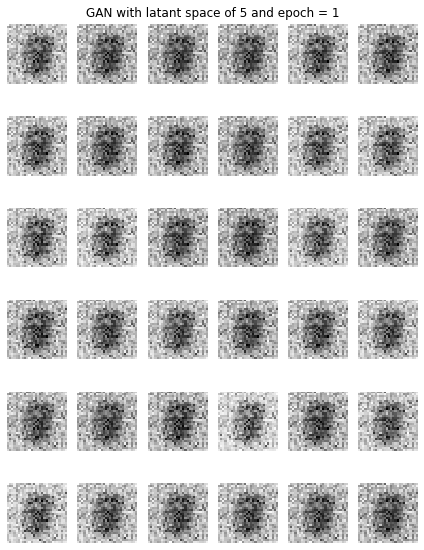

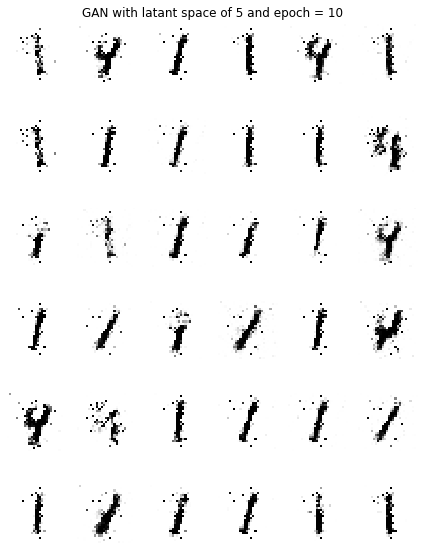

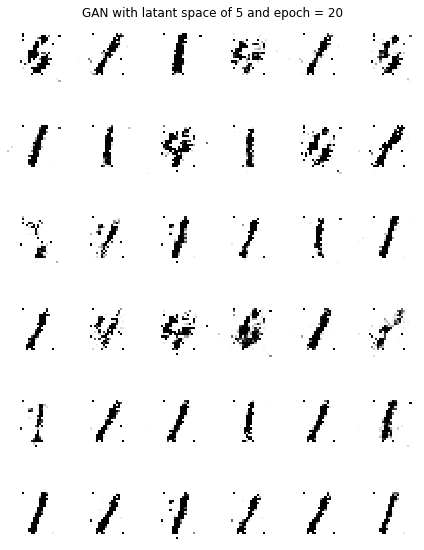

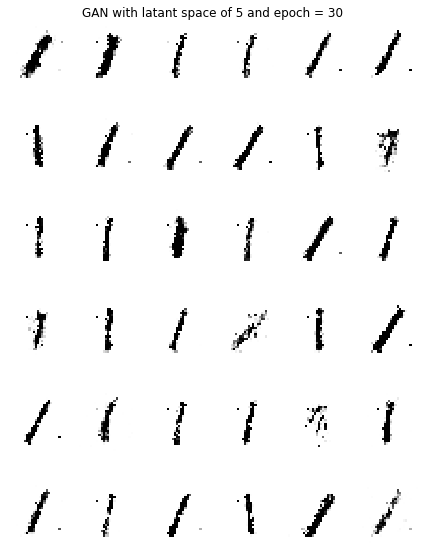

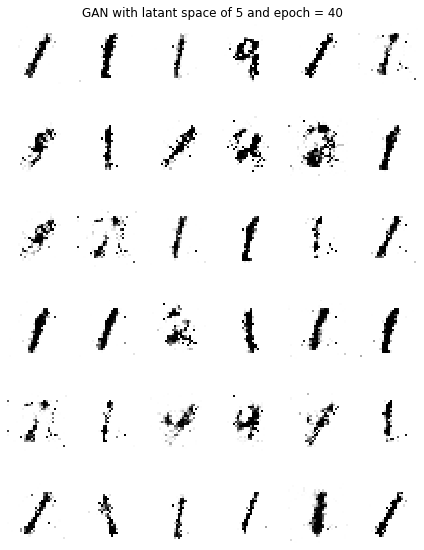

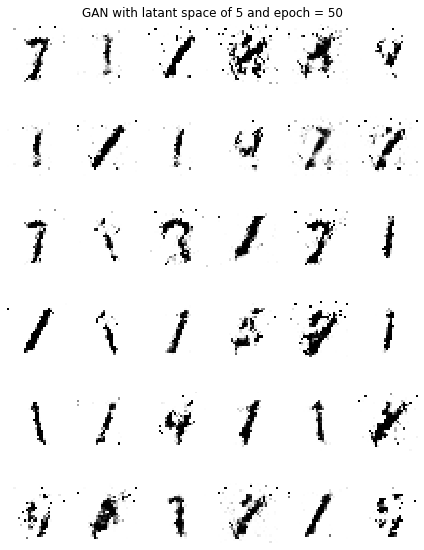

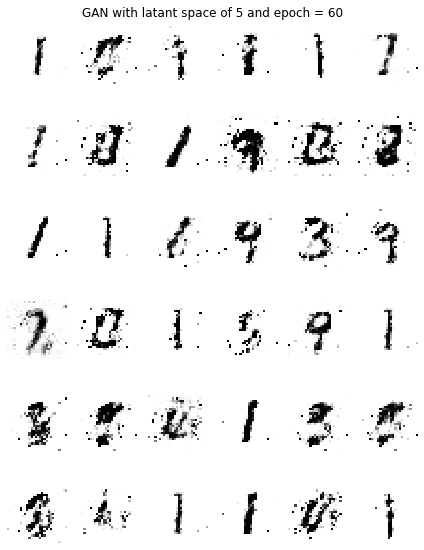

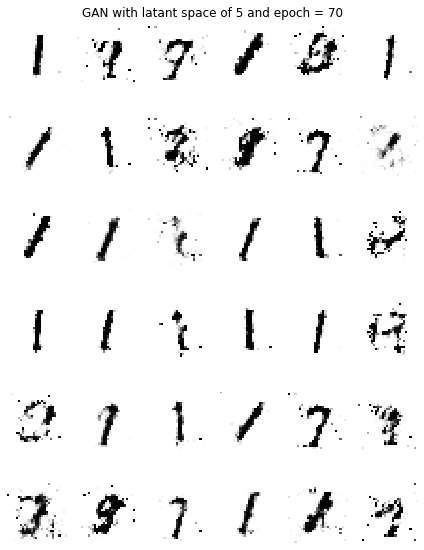

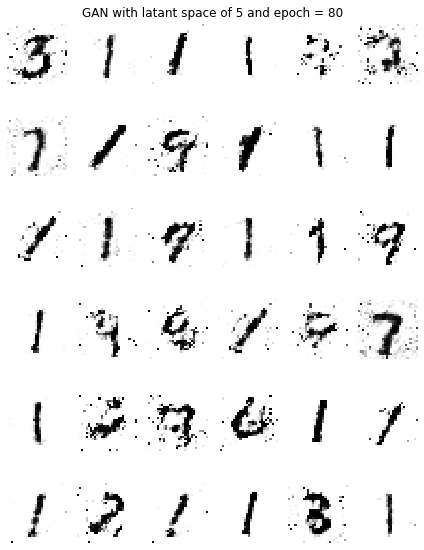

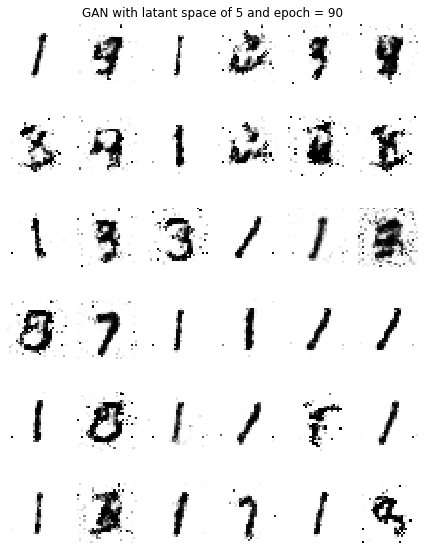

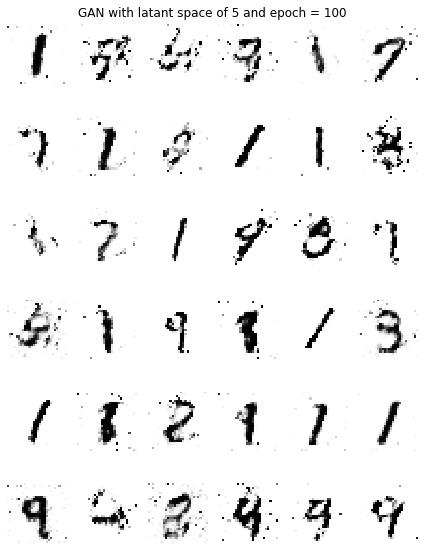

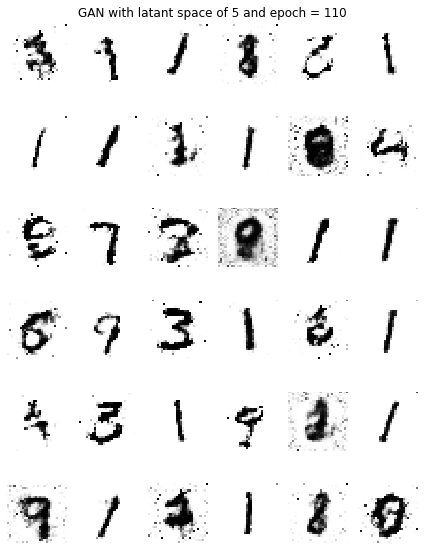

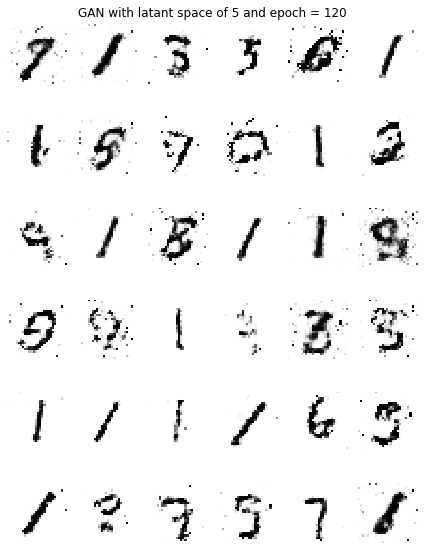

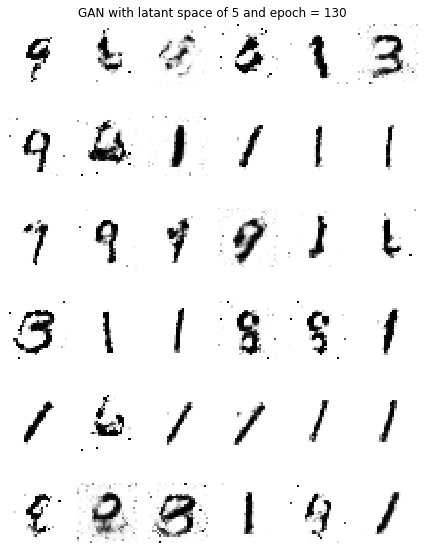

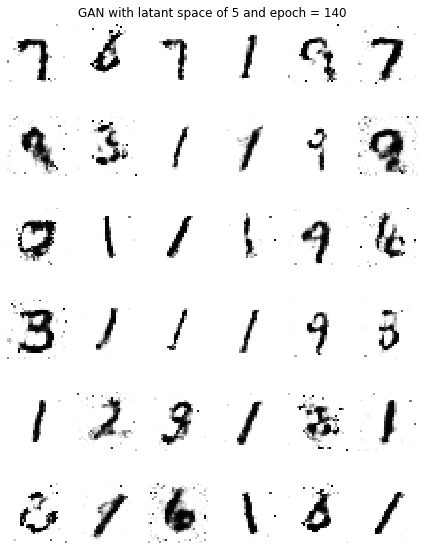

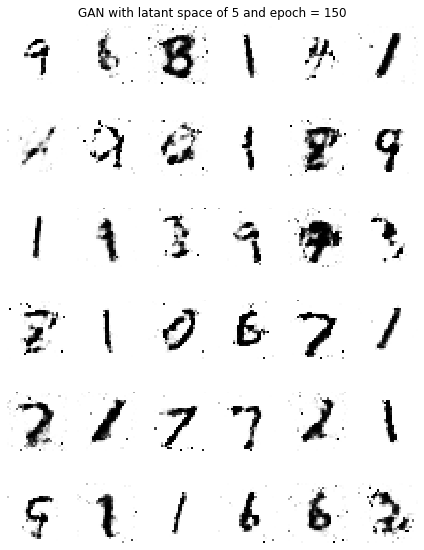

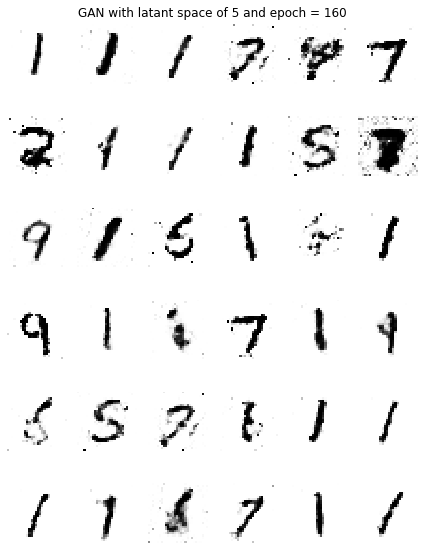

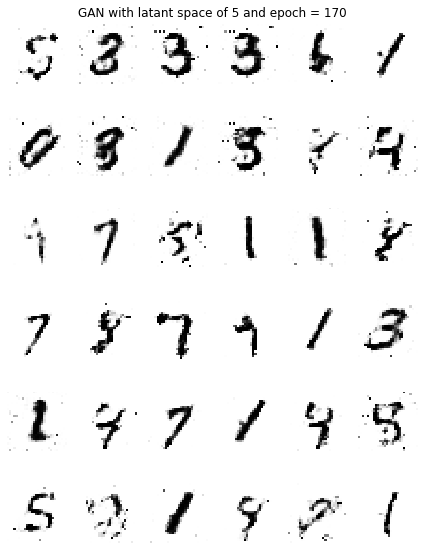

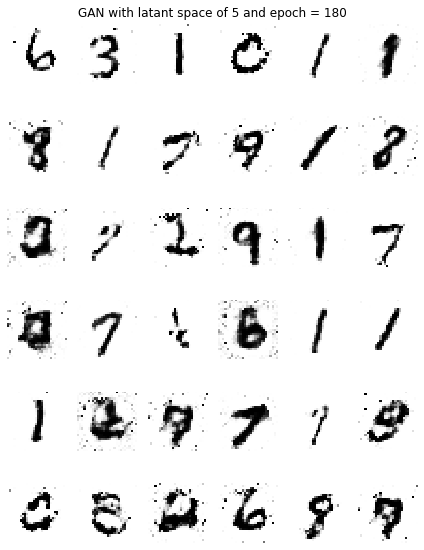

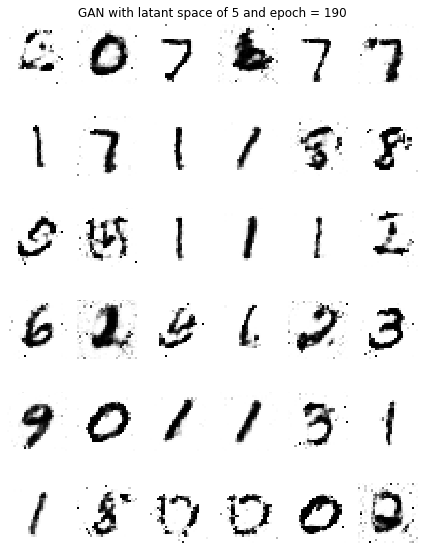

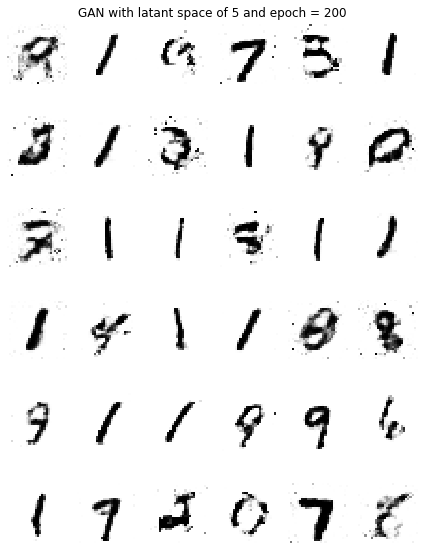

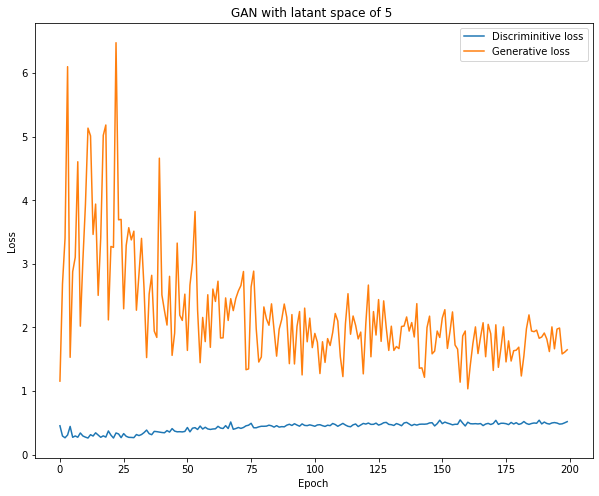

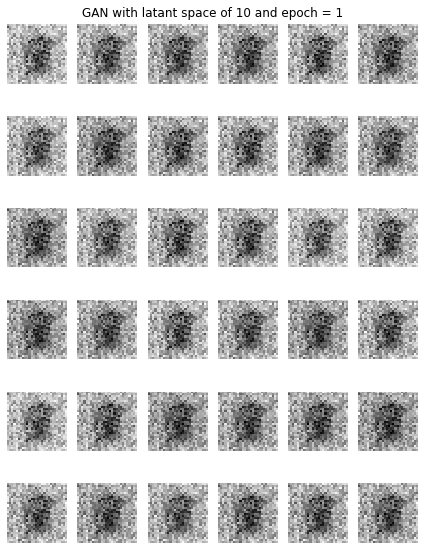

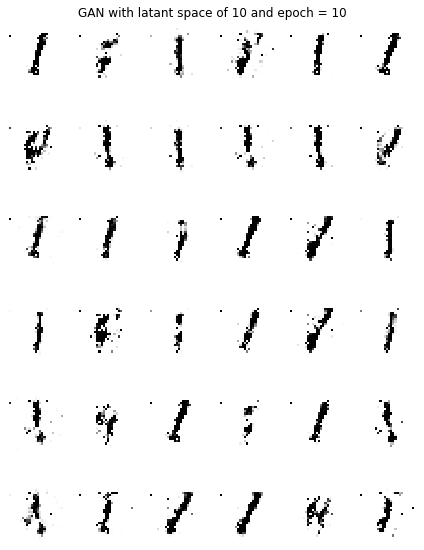

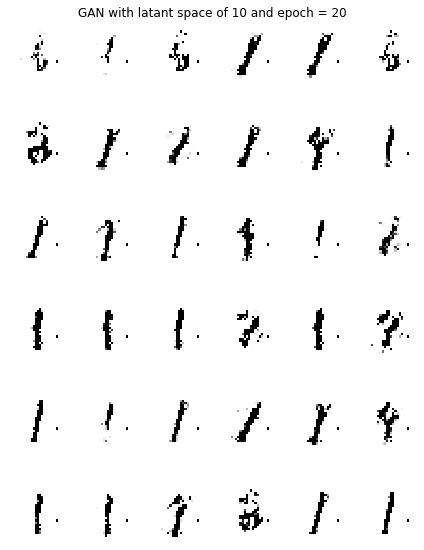

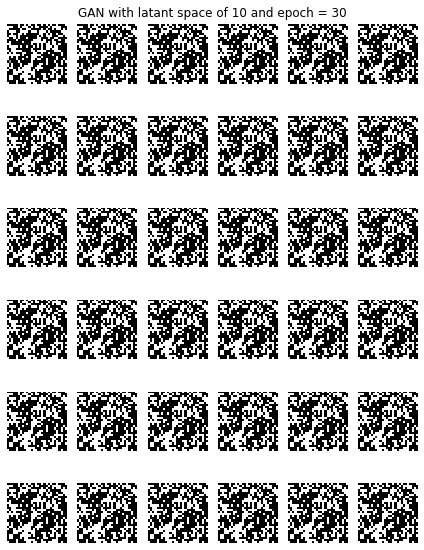

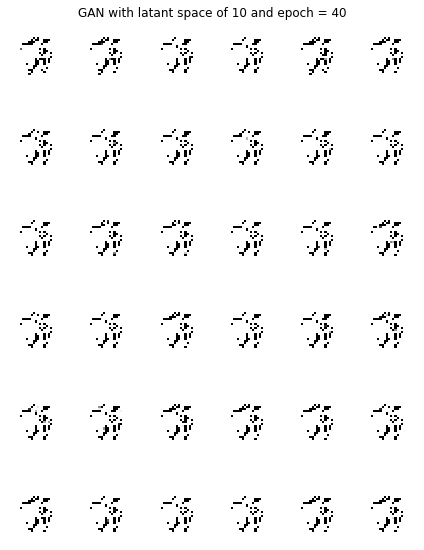

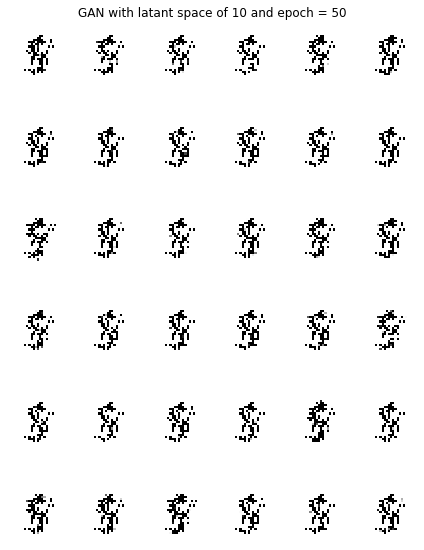

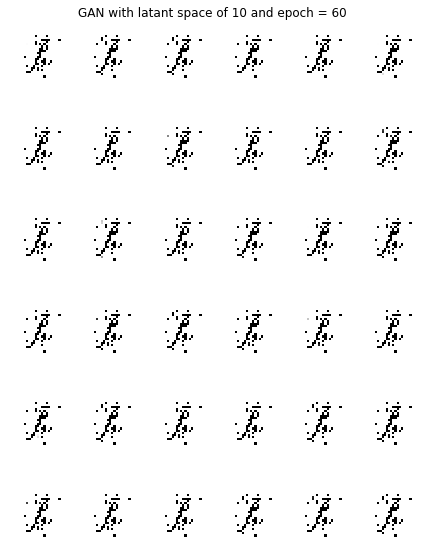

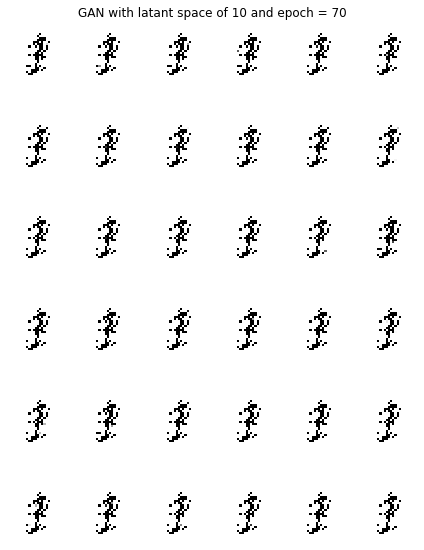

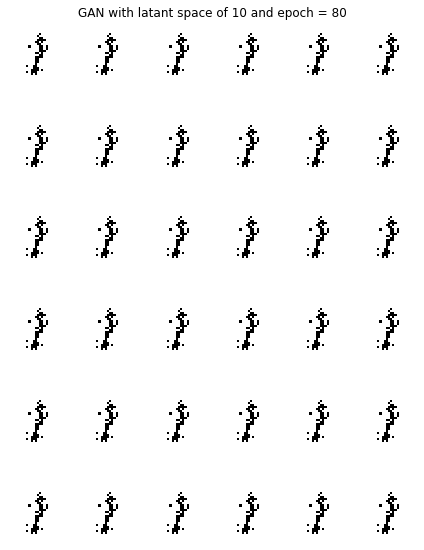

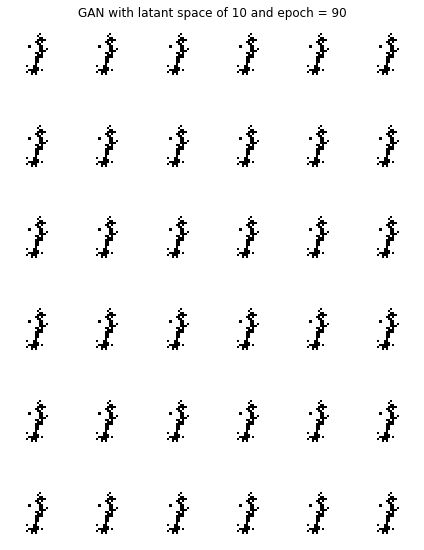

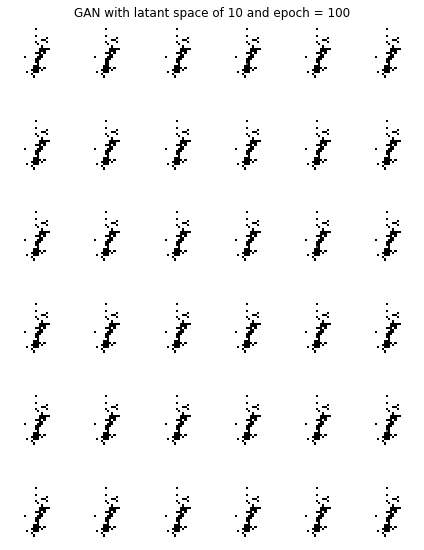

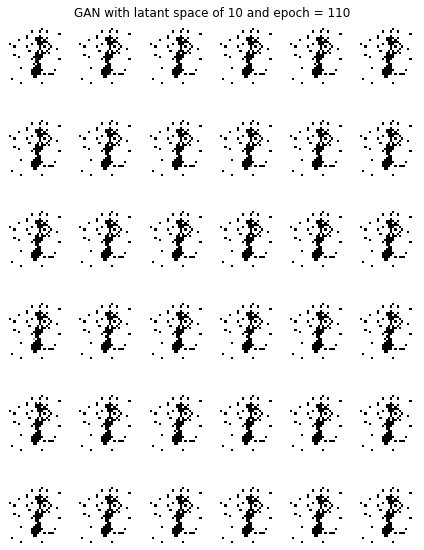

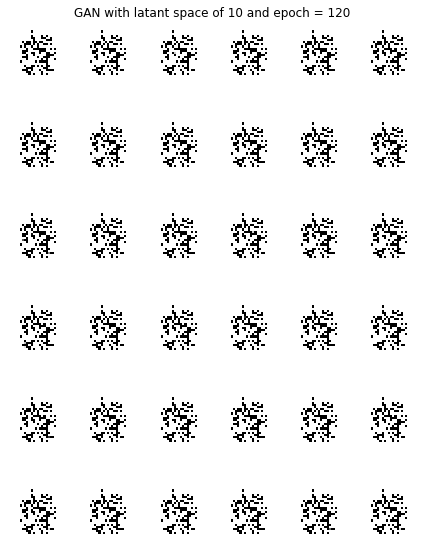

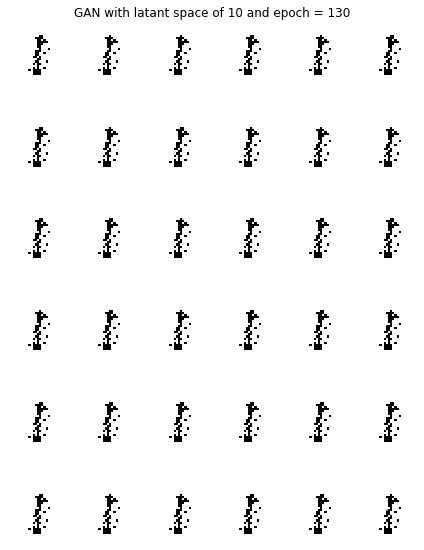

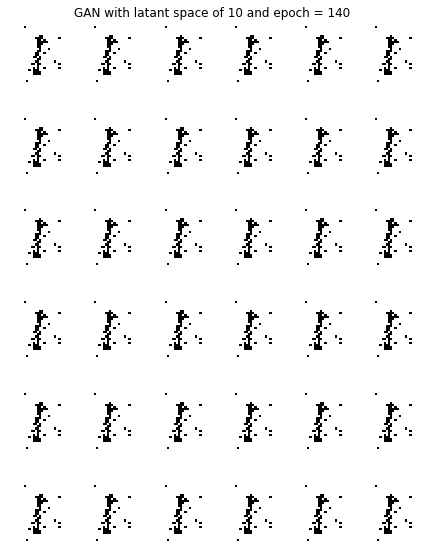

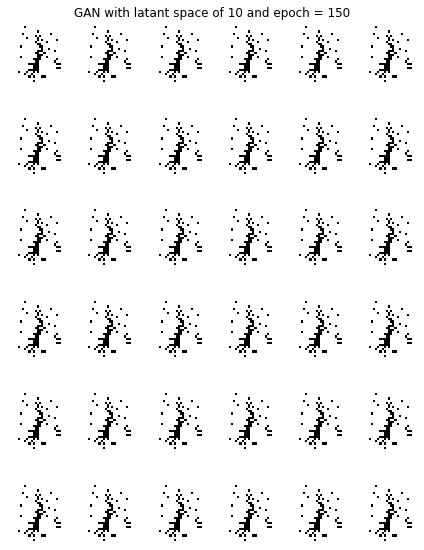

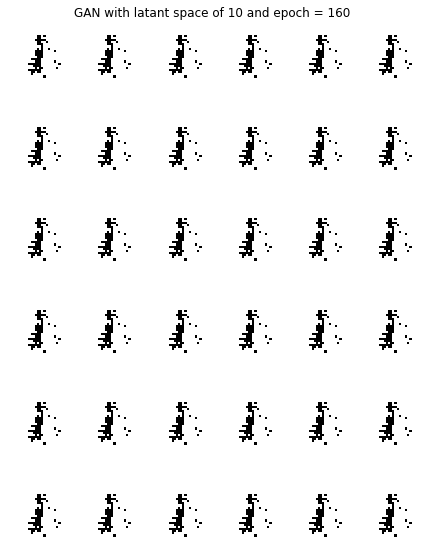

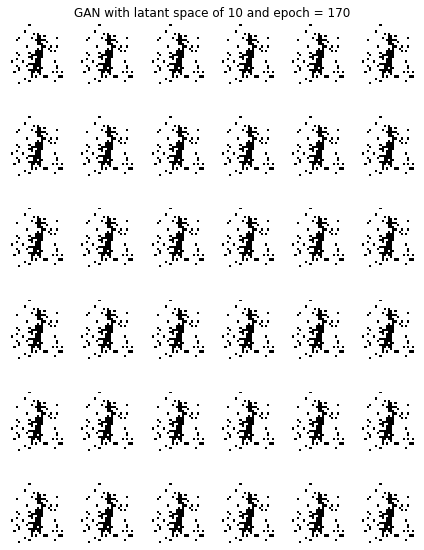

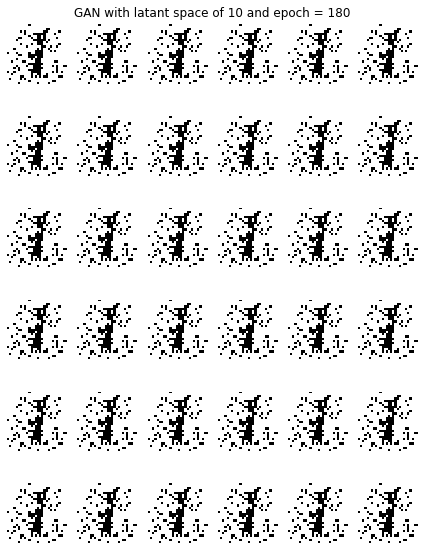

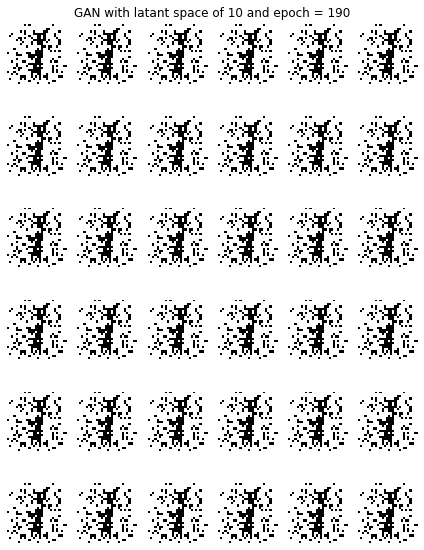

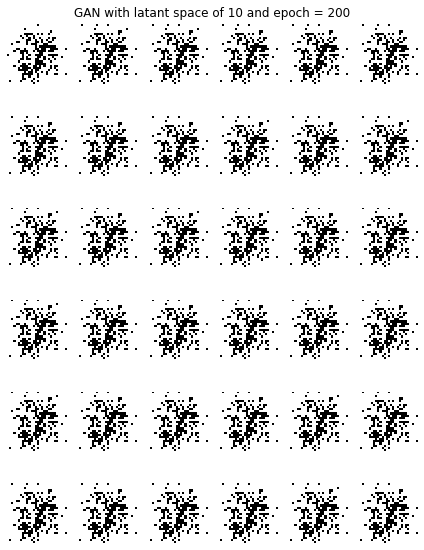

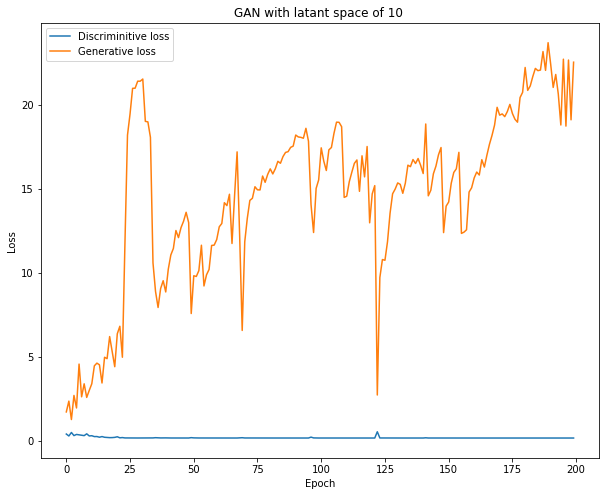

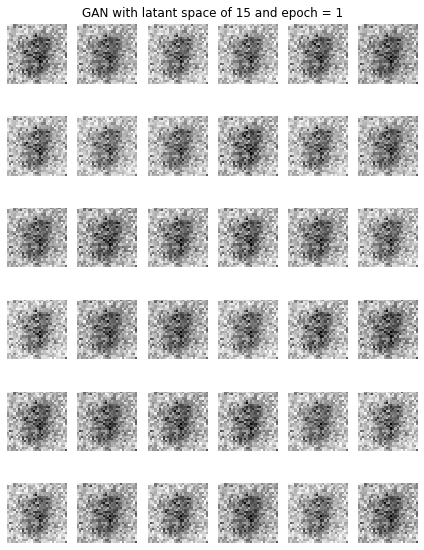

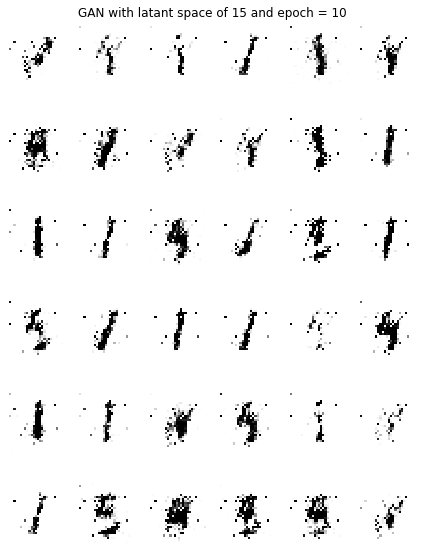

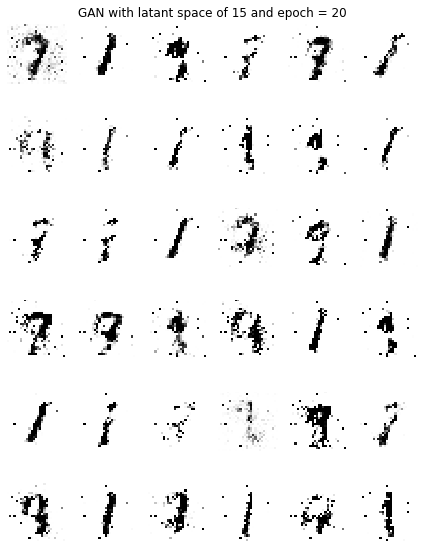

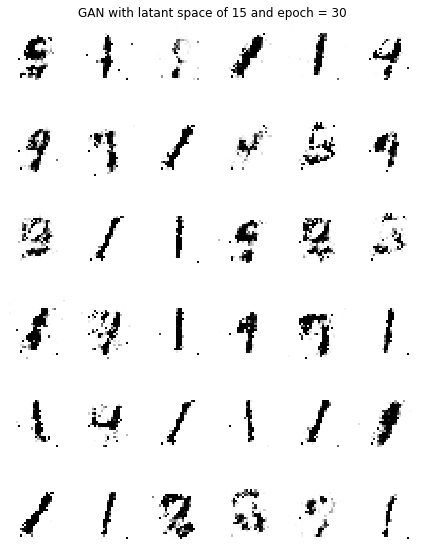

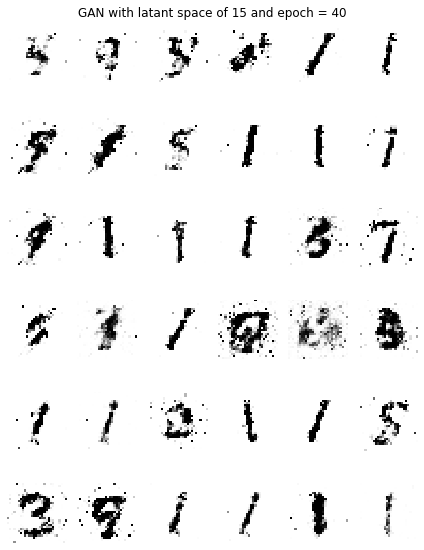

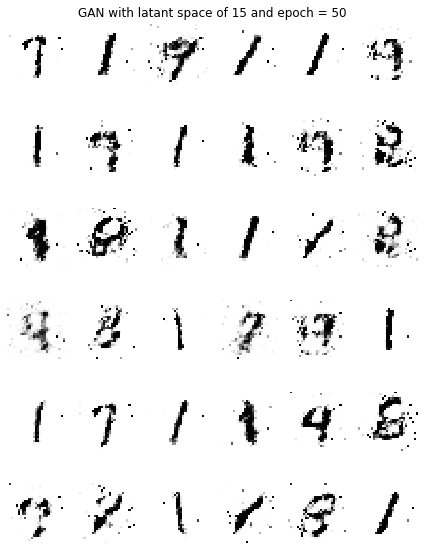

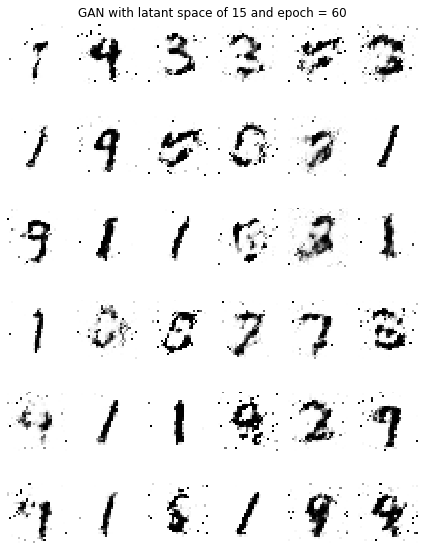

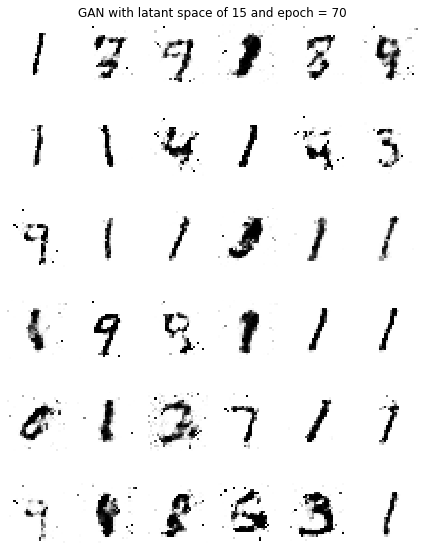

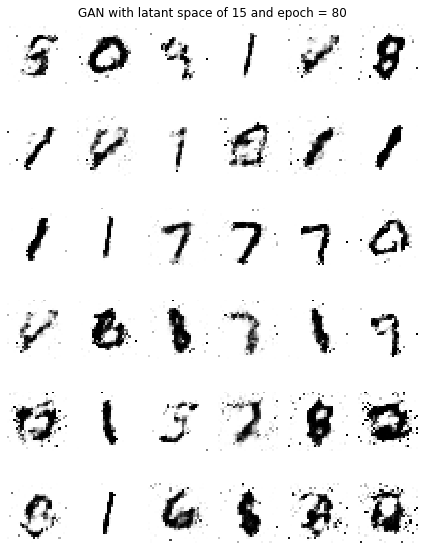

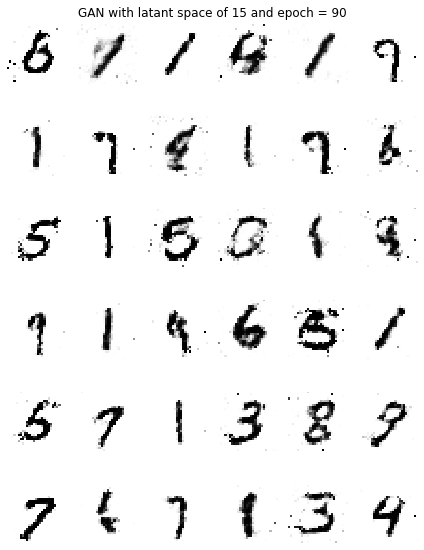

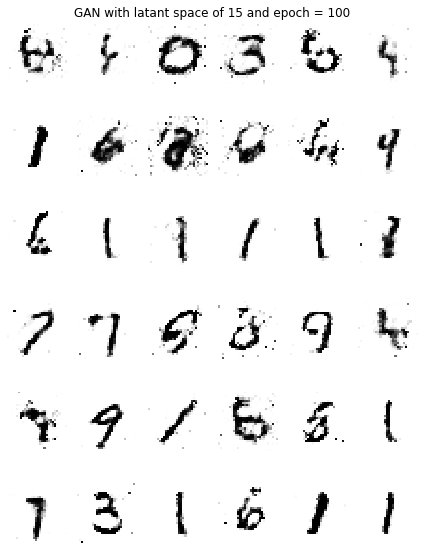

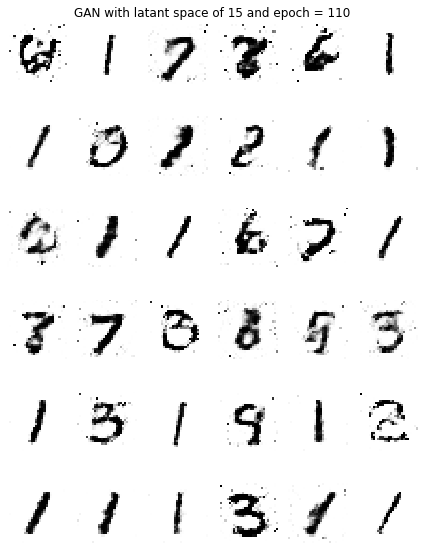

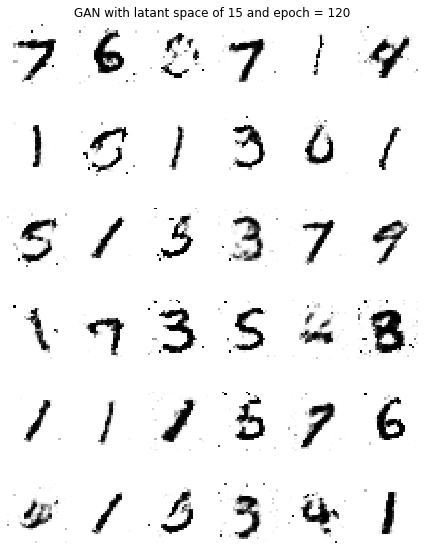

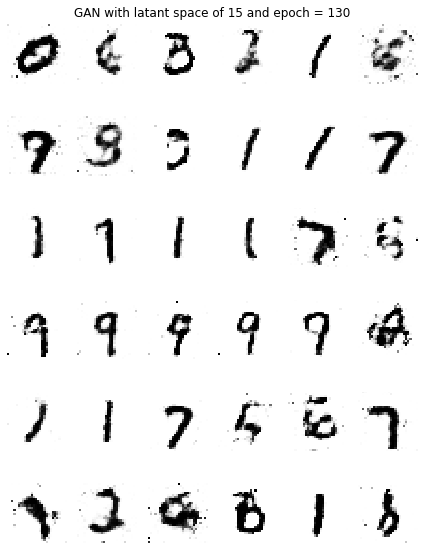

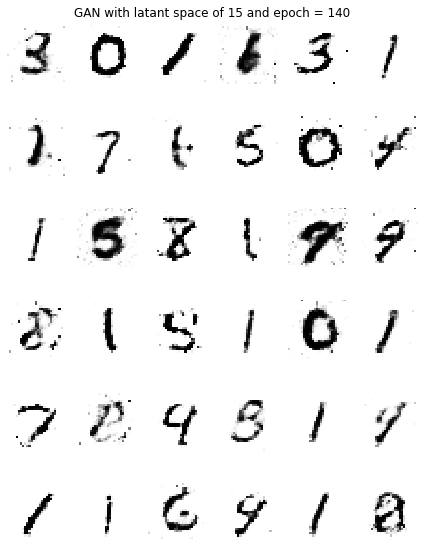

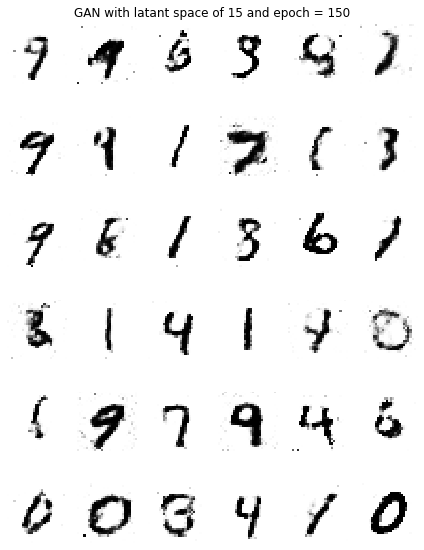

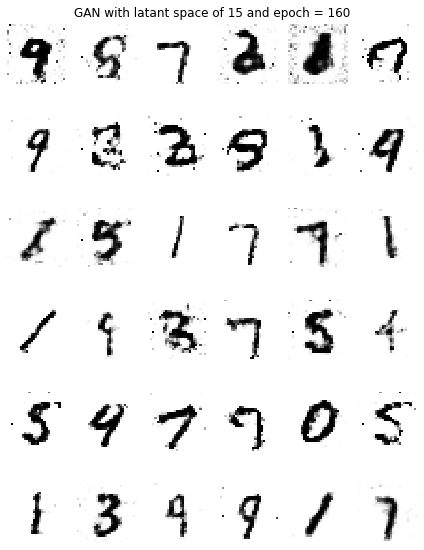

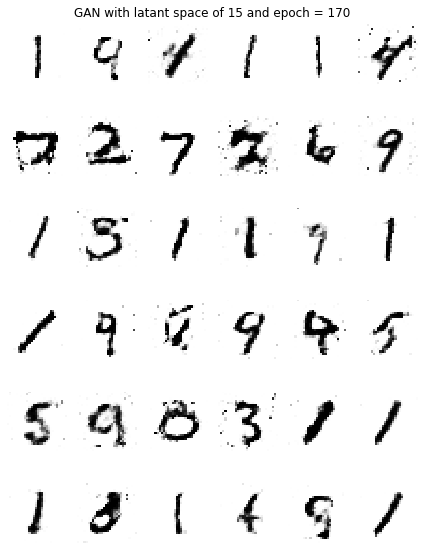

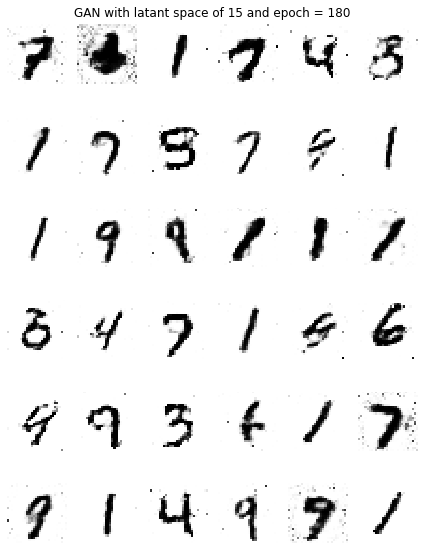

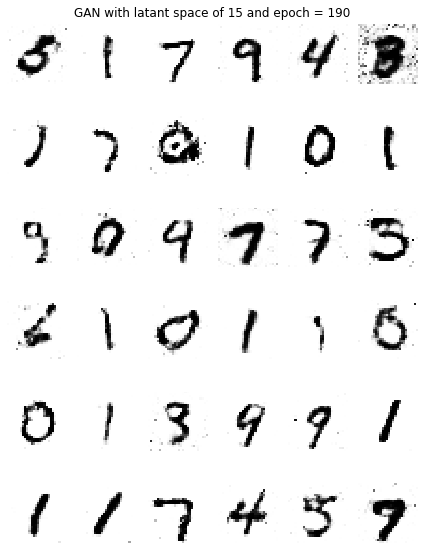

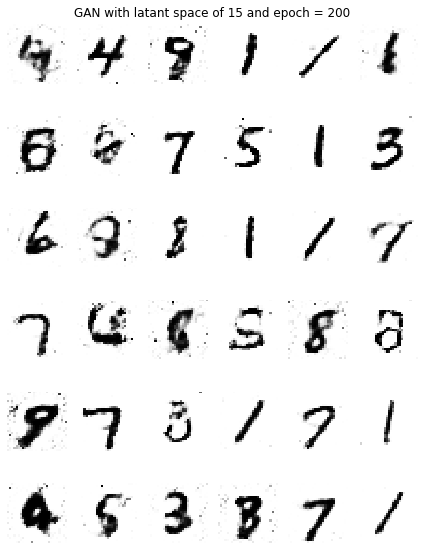

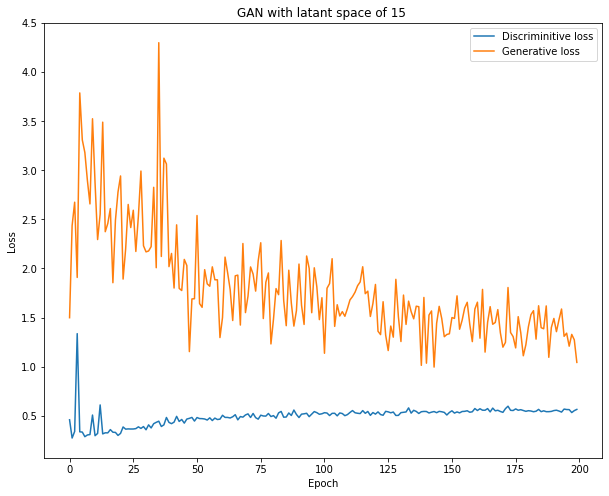

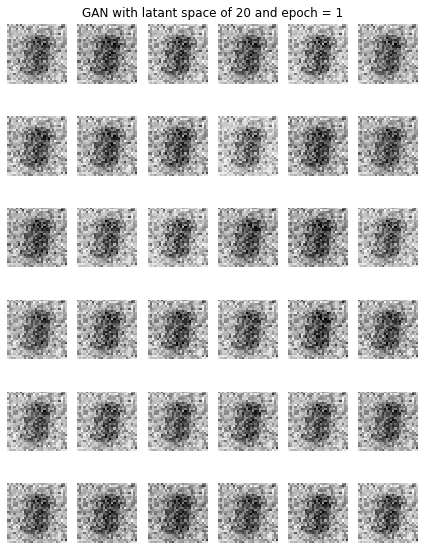

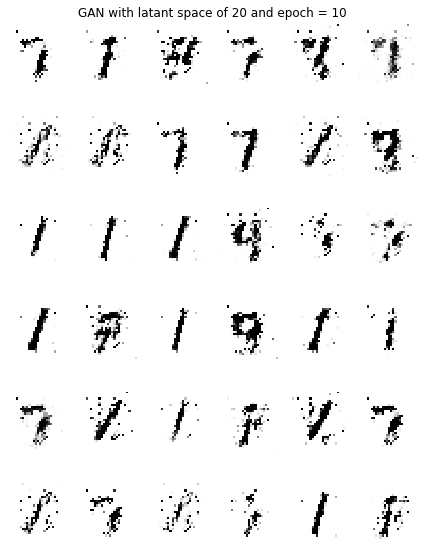

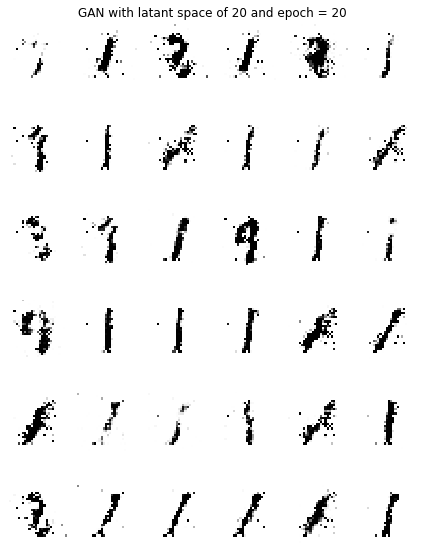

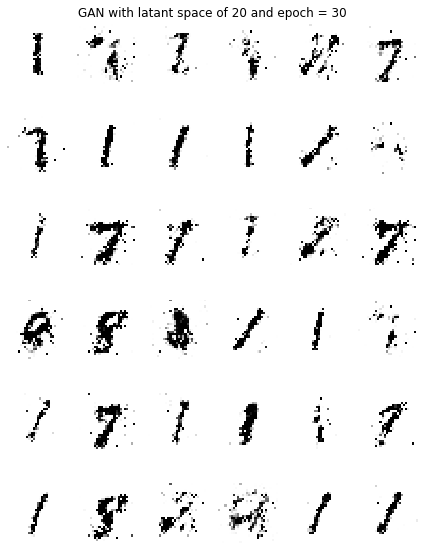

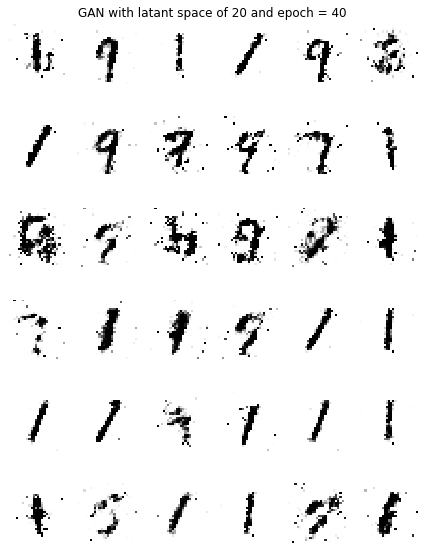

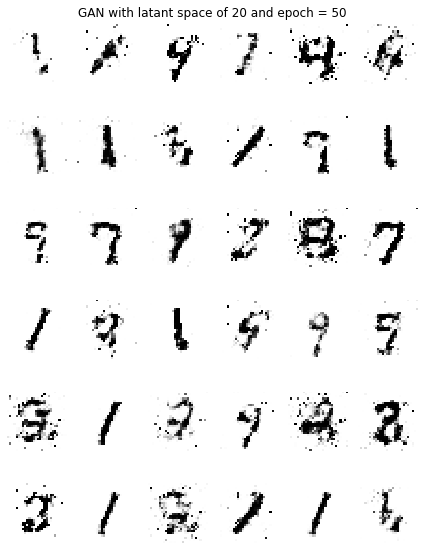

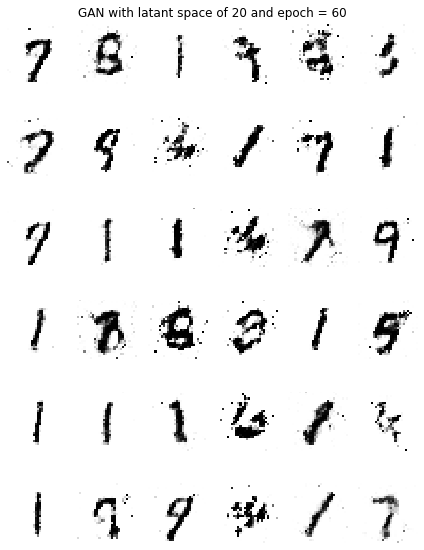

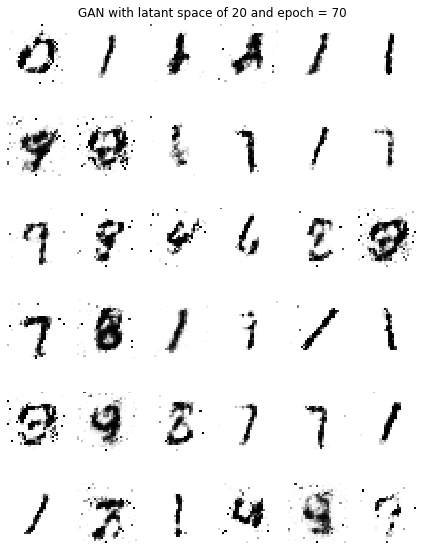

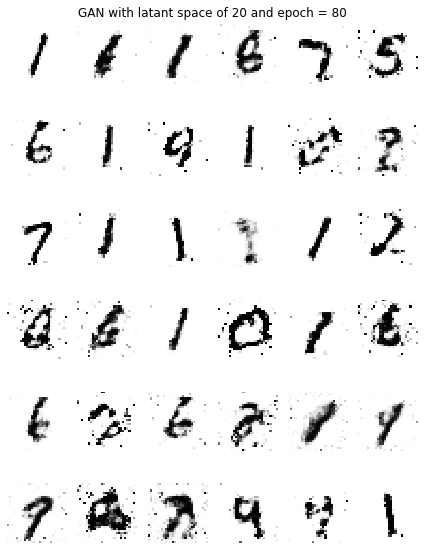

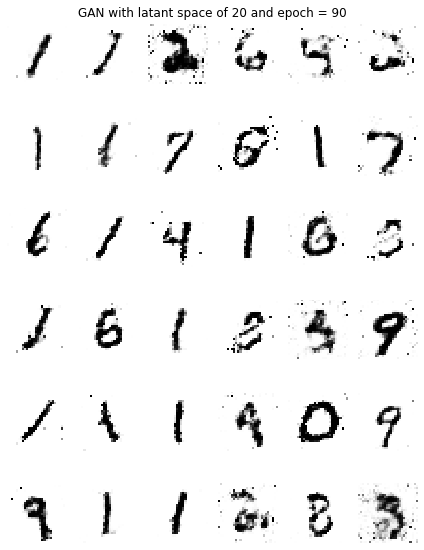

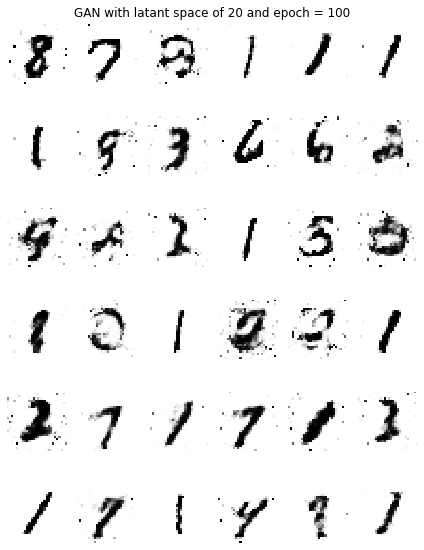

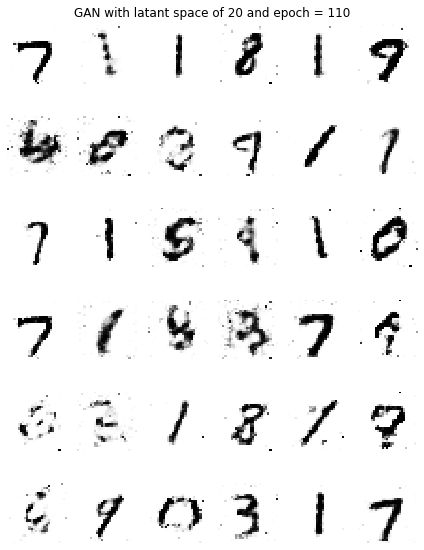

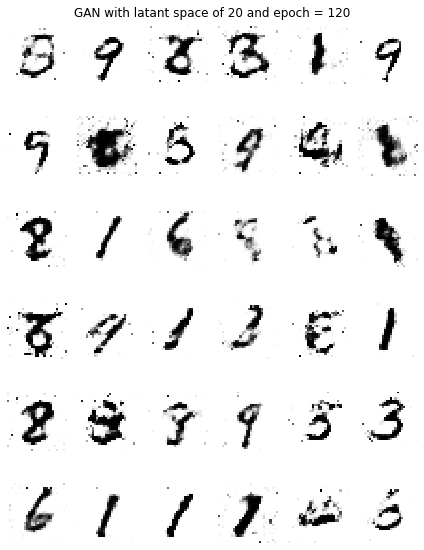

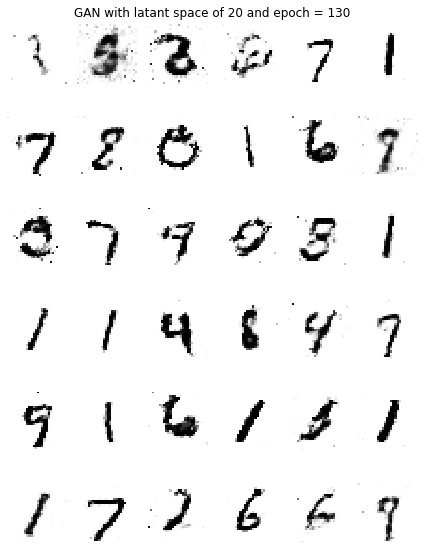

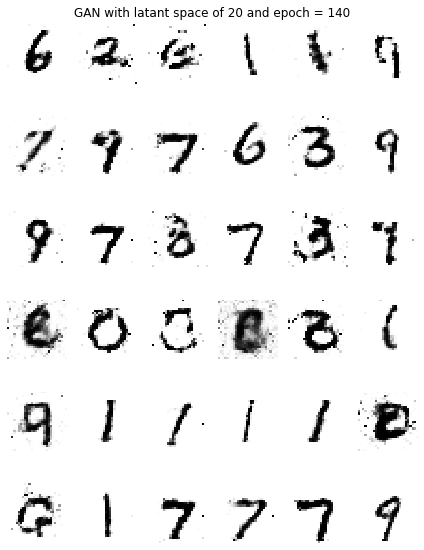

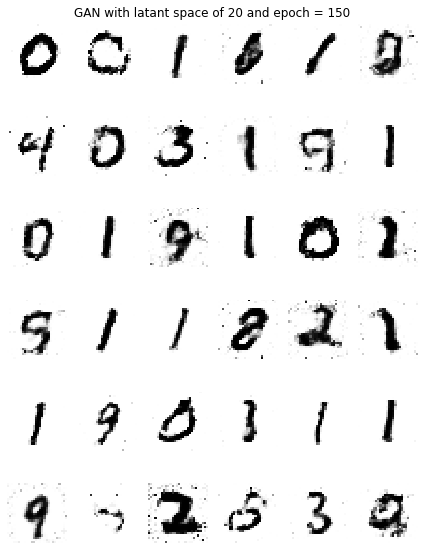

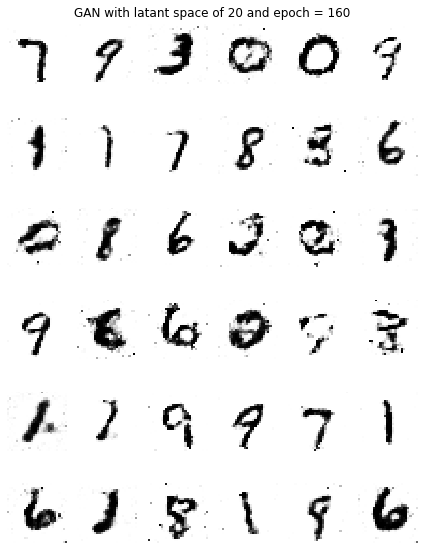

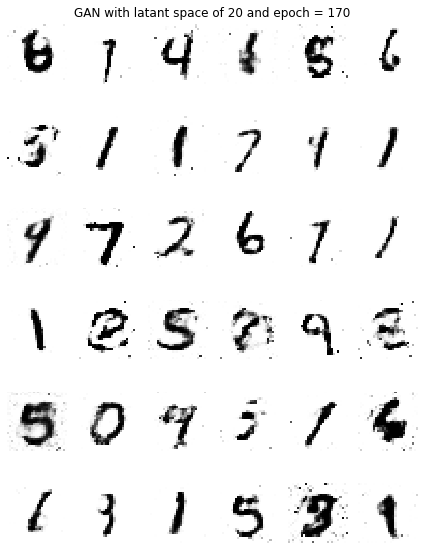

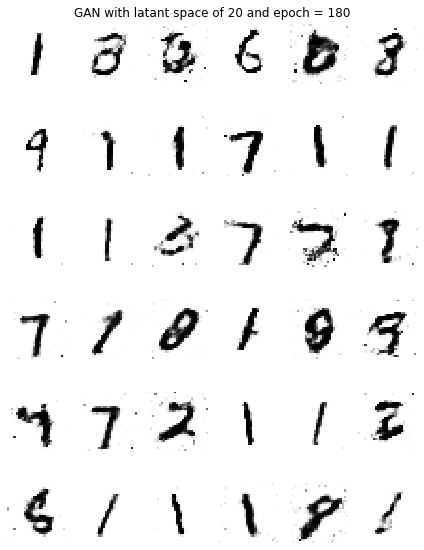

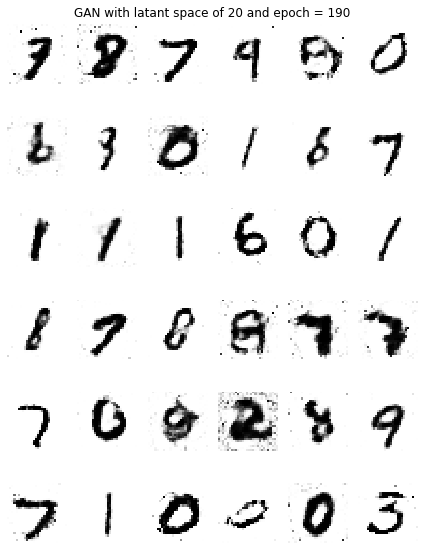

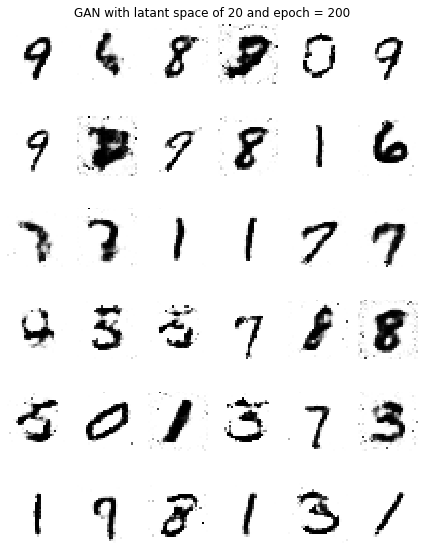

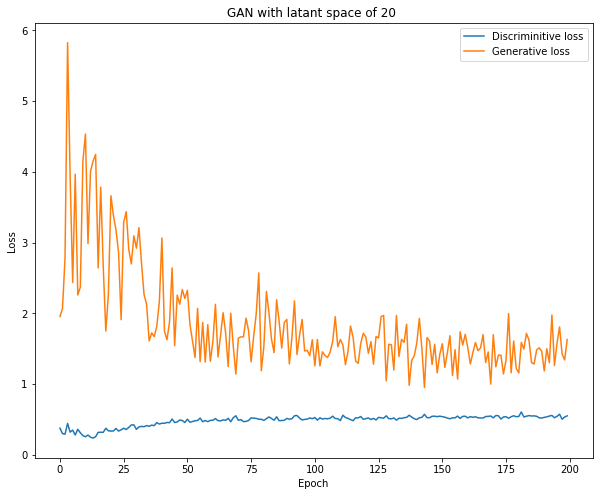

In [2]:
input_dim_list = [5,10,15,20]

for input in input_dim_list:
  train_input_dim(input, 200, 512)

  0%|          | 0/96 [00:00<?, ?it/s]

Epochs: 50
Batch size: 624
Batches per epoch: 96.15384615384616
randomDim:  10
--------------- Epoch 1 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.15it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.95it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 2/96 [00:00<00:07, 13.14it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.33it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 2/96 [00:00<00:05, 15.68it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.57it/s]

--------------- Epoch 7 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.43it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.78it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.42it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.78it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.93it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.79it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 2/96 [00:00<00:06, 13.80it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.03it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.99it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.54it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.77it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.29it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.44it/s]

--------------- Epoch 20 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.47it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.02it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.58it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 2/96 [00:00<00:05, 15.75it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.39it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.60it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.56it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.54it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.99it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.75it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.75it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.72it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.53it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.34it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.66it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 2/96 [00:00<00:06, 13.77it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 2/96 [00:00<00:05, 15.98it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.42it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 2/96 [00:00<00:06, 13.72it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 2/96 [00:00<00:06, 13.88it/s]

--------------- Epoch 40 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.14it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 2/96 [00:00<00:05, 16.13it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.61it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 2/96 [00:00<00:05, 15.69it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 2/96 [00:00<00:06, 14.60it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.43it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 2/96 [00:00<00:06, 15.38it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 2/96 [00:00<00:05, 16.05it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 2/96 [00:00<00:05, 16.19it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 2/96 [00:00<00:05, 15.70it/s]

--------------- Epoch 50 ---------------


100%|██████████| 96/96 [00:06<00:00, 15.00it/s]


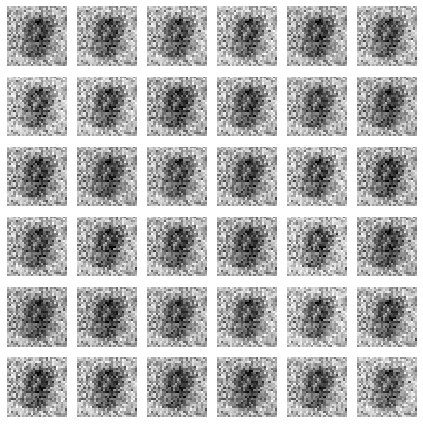

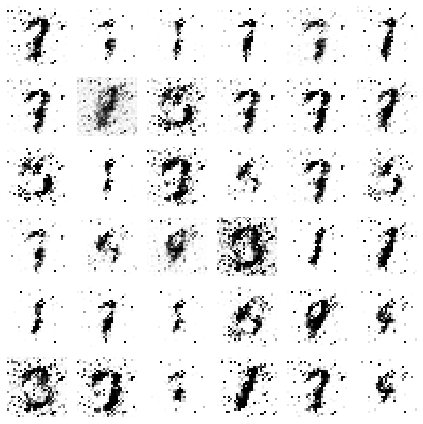

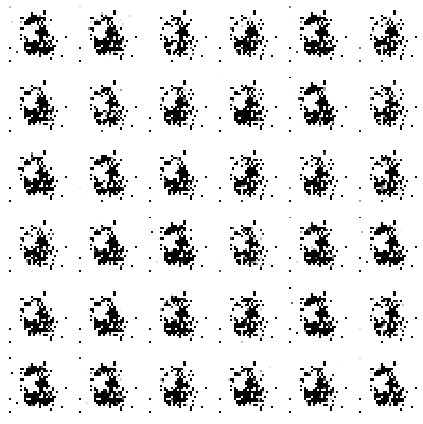

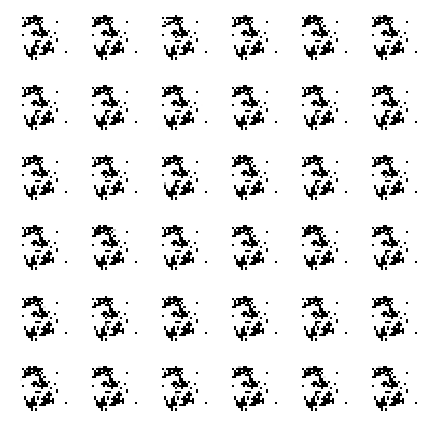

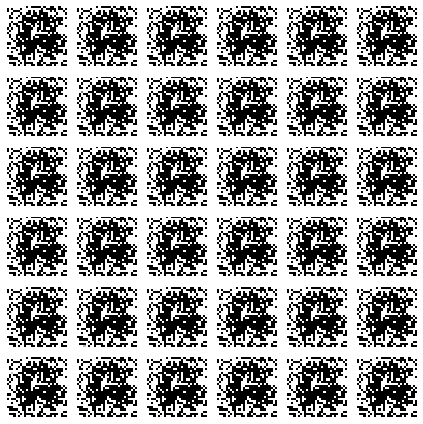

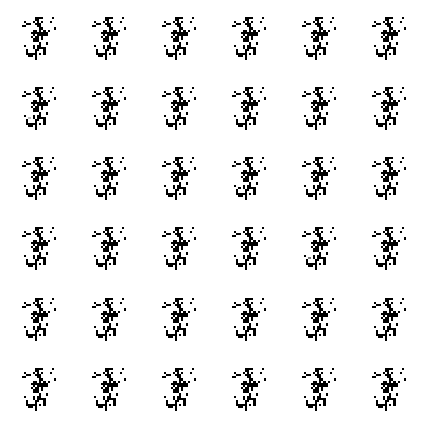

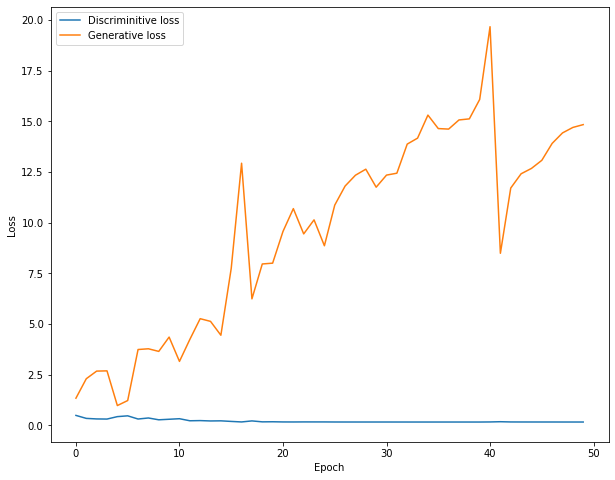

In [26]:
train(10,512)